In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

### Additional functions

In [ ]:
def compute_average_confusion_matrix(results):
    """
    Compute the element-wise average of confusion matrices.
    """
    conf_matrices = [res['conf'] for res in results]
    avg_matrix = np.mean(conf_matrices, axis=0)
    return avg_matrix

def plot_confusion_matrix(result, class_names, average=False):
    """
    Plot the confusion matrix with class labels.
    """
    if average:
        conf_matrix = compute_average_confusion_matrix(result)
        title = "Averaged Confusion Matrix"
        fmt = '.2f'
    else:
        conf_matrix = result['conf']
        title = f"Confusion Matrix - {result['model'].upper()}"
        fmt = 'd'

    plt.figure(figsize=(24, 20))
    sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_multiple_confusion_matrices(results, class_names, dataset_type):
    """
    Plot confusion matrices for multiple classifiers side by side.
    """
    num_models = len(results)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))

    for i, result in enumerate(results):
        ax = axes[i] if num_models > 1 else axes
        sns.heatmap(result['conf'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    cbar=False, ax=ax)
        ax.set_title(f"{result['model'].upper()}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.tick_params(axis='x', rotation=45)

    fig.suptitle(f"Confusion Matrices - {dataset_type}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_clip_zcr_mfcc(filepath, label, ax):
    """
    Plot a single audio clip's ZCR and MFCC on a compact subplot with insets.
    """
    y, sr = librosa.load(filepath, sr=None)

    ax.axis('off')

    zcr = librosa.feature.zero_crossing_rate(y)[0]
    ax_zcr = ax.inset_axes([0, 0.7, 1.0, 0.3])
    ax_zcr.plot(zcr, color='blue')
    ax_zcr.set_title(label, fontsize=6, pad=2)
    ax_zcr.axis('off')

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    ax_mfcc = ax.inset_axes([0, 0.0, 1.0, 0.7])
    librosa.display.specshow(mfccs, sr=sr, x_axis=None, ax=ax_mfcc)
    ax_mfcc.axis('off')

def plot_dataset_overview(df, num_categories=5, clips_per_category=5):
    fig, axes = plt.subplots(num_categories, clips_per_category, figsize=(clips_per_category * 2, num_categories * 2))
    fig.suptitle("Waveform ZCR (top) + MFCC (bottom) Overview", fontsize=14)
    fig.subplots_adjust(hspace=0.5)

    for i, label in enumerate(df.label.unique()[:num_categories]):
        samples = df[df.label == label].head(clips_per_category)
        for j, (_, row) in enumerate(samples.iterrows()):
            y, sr = librosa.load(row.filepath, sr=None)
            plot_clip_zcr_mfcc(y, sr, label, axes[i, j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_classwise_recall_from_confusion(results, df_classes, dataset_name="ESC-10", title_suffix="(No PCA)"):
    """
    Plot classwise recall from confusion matrices in results.

    Args:
        results (list): Each dict must contain 'conf', 'model', and 'dataset'.
        df_classes (pd.DataFrame): Must have 'target' and 'category' columns.
        dataset_name (str): Title label.
        title_suffix (str): Optional suffix.
    """
    recall_data = []

    target_to_label = df_classes[['target', 'category']].drop_duplicates().sort_values('target')
    class_labels = target_to_label['category'].tolist()

    for res in results:
        conf = res['conf']
        model = res['model']
        dataset = res['dataset']

        for idx, label in enumerate(class_labels):
            tp = conf[idx, idx]
            fn = np.sum(conf[idx, :]) - tp
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

            recall_data.append({
                'event': label,
                'recall': recall,
                'model': model,
                'dataset': dataset
            })

    df_recall = pd.DataFrame(recall_data)
    events = sorted(df_recall['event'].unique())[::-1]

    marker_map = {
        ('rf', 'ESC-10'): 'p',
        ('svm', 'ESC-10'): 'h',
        ('knn', 'ESC-10'): 's',
        ('rf', 'ESC-50'): 'P',
        ('svm', 'ESC-50'): 'H',
        ('knn', 'ESC-50'): 'o',
    }
    color_map = {
        ('rf', 'ESC-10'): '#e41a1c',
        ('svm', 'ESC-10'): '#ff7f00',
        ('knn', 'ESC-10'): '#4daf4a',
        ('rf', 'ESC-50'): '#e41a1c',
        ('svm', 'ESC-50'): '#ff7f00',
        ('knn', 'ESC-50'): '#4daf4a',
    }

    plt.figure(figsize=(10, 14))
    for (model, dataset), group in df_recall.groupby(['model', 'dataset']):
        xs = group['recall']
        ys = group['event'].apply(lambda x: events.index(x))
        plt.scatter(xs, ys,
                    label=f'{model.upper()} ({dataset})',
                    marker=marker_map.get((model, dataset), 'o'),
                    color=color_map.get((model, dataset), 'gray'),
                    s=100,
                    edgecolors='black')

    plt.yticks(ticks=range(len(events)), labels=events)
    plt.xlabel('Recall')
    plt.ylabel('Type of sound event')
    plt.title(f'Recall per Class for {dataset_name} {title_suffix}')
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.xlim(0, 1)
    plt.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### Load and preprocess data

In [56]:
class ESCData:
    """
    Loader for ESC-50 metadata and audio.
    """
    def __init__(self, dataset_path, csv_path='meta/esc50.csv', audio_folder='audio', sr=44100, duration=5.0):
        df = pd.read_csv(os.path.join(dataset_path, csv_path))
        df['filepath'] = df['filename'].apply(lambda f: os.path.join(dataset_path, audio_folder, f))
        self.df = df
        self.sr = sr
        self.duration = duration

In the initial paper there were 2 datasets: `ESC-10` and `ESC-50`. Given that datasets were merged into `ESC-50`.

In [57]:
dataset_path = 'ESC-50-master'
data = ESCData(dataset_path)

We can see here column `esc10` which states to which dataset does the following sound belong. Fold column is for cross-validation.

In [58]:
data.df.head()

,filename,fold,target,category,esc10,src_file,take,filepath
0,1-100032-A-0.wav,1,0,dog,True,100032,A,ESC-50-master/audio/1-100032-A-0.wav
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,ESC-50-master/audio/1-100038-A-14.wav
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,ESC-50-master/audio/1-100210-A-36.wav
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,ESC-50-master/audio/1-100210-B-36.wav
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,ESC-50-master/audio/1-101296-A-19.wav


In [64]:
data.df['filename'].head()

0     1-100032-A-0.wav
1    1-100038-A-14.wav
2    1-100210-A-36.wav
3    1-100210-B-36.wav
4    1-101296-A-19.wav
Name: filename, dtype: object

In [65]:
len(data.df['filename'])

2000

In [66]:
class FeatureExtractor:
    """
    Compute summary MFCC and ZCR features.
    """
    def __init__(self, sr=44100, n_mfcc=13, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.hop_length = hop_length

    def extract(self, y):
        mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc, hop_length=self.hop_length)
        zcr = librosa.feature.zero_crossing_rate(y=y, hop_length=self.hop_length)
        stats = []
        for arr in (mfcc, zcr):
            stats.extend(arr.mean(axis=1))
            stats.extend(arr.std(axis=1))
        return np.array(stats)

In [67]:
fe = FeatureExtractor()

Here we prepare sepparately `ESC-50` and `ESC-10` subsets and see what classes do they have

In [90]:
df50 = data.df
X50 = np.array([fe.extract(librosa.load(fp, sr=data.sr, duration=data.duration)[0]) for fp in df50['filepath']])
y50 = df50['target'].values
folds50 = df50['fold']
df50_classes = df50['category'].unique()

In [92]:
df50_classes[:5]

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock'], dtype=object)

In [91]:
df10 = df50[df50['esc10']]
X10 = np.array([fe.extract(librosa.load(fp, sr=data.sr, duration=data.duration)[0]) for fp in df10['filepath']])
y10 = df10['target'].values
folds10 = df10['fold']
df10_classes = df10['category'].unique()

In [93]:
df10_classes

array(['dog', 'chainsaw', 'crackling_fire', 'helicopter', 'rain',
       'crying_baby', 'clock_tick', 'sneezing', 'rooster', 'sea_waves'],
      dtype=object)

### EDA

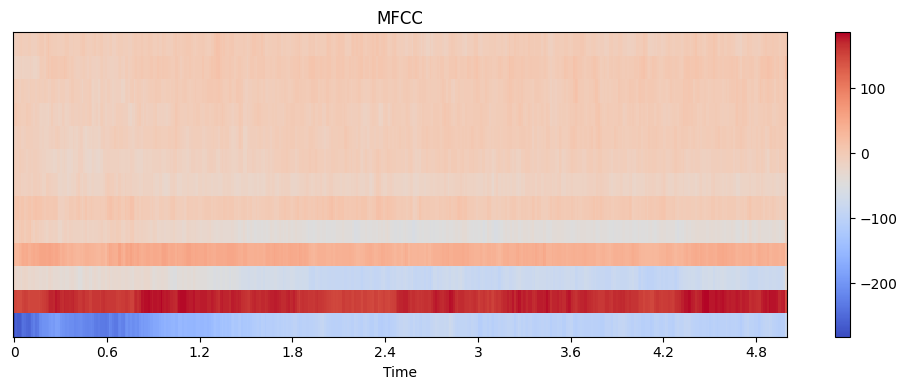

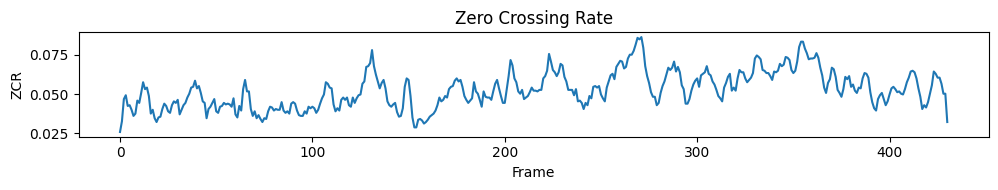

In [123]:
file_path = df10.iloc[2].filepath
y, sr = librosa.load(file_path, sr=44100, duration=5.0)

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
zcr = librosa.feature.zero_crossing_rate(y=y)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(zcr[0])
plt.title('Zero Crossing Rate')
plt.xlabel('Frame')
plt.ylabel('ZCR')
plt.tight_layout()
plt.show()

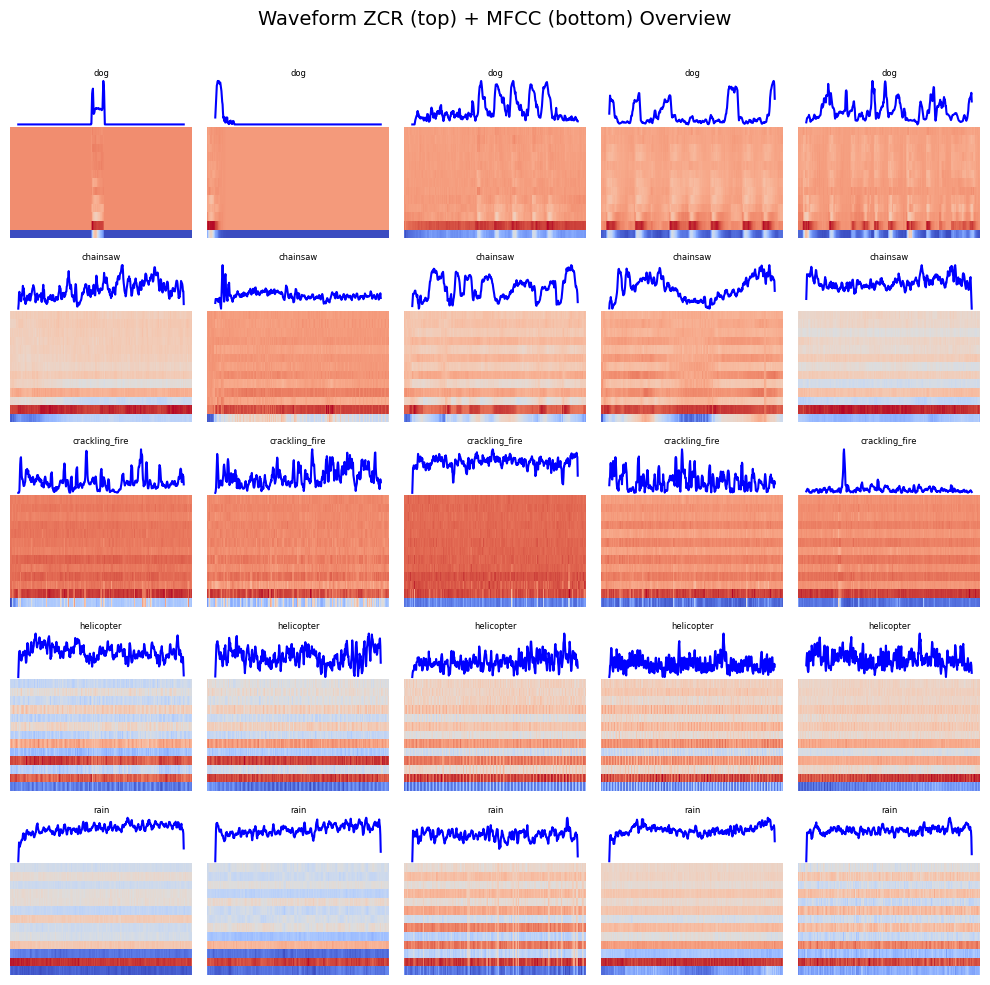

In [ ]:
categories = 5
clips_per_cat = 5

samples = []
for category in df10['category'].unique()[:categories]:
    samples.extend(df10[df10['category'] == category].head(clips_per_cat).to_dict('records'))

fig, axes = plt.subplots(categories, clips_per_cat, figsize=(clips_per_cat*2, categories*2))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for idx, sample in enumerate(samples):
    row = idx // clips_per_cat
    col = idx % clips_per_cat
    ax = axes[row, col]
    plot_clip_zcr_mfcc(sample['filepath'], sample['category'], ax)

plt.suptitle("Waveform ZCR (top) + MFCC (bottom) Overview", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The ESC-10 dataset displays strong consistency within each class and clear separability between different classes. Most sounds can be grouped into broader categories such as transient or percussive events (like sneezing, dog barking, or a ticking clock), sounds with rich harmonic content (such as a baby crying or a rooster crowing), and more continuous, noisy soundscapes (like rain, ocean waves, or helicopter noise). The main classification challenges are likely to arise within these groups, for example, distinguishing between similar ambient sounds like rain and sea waves.

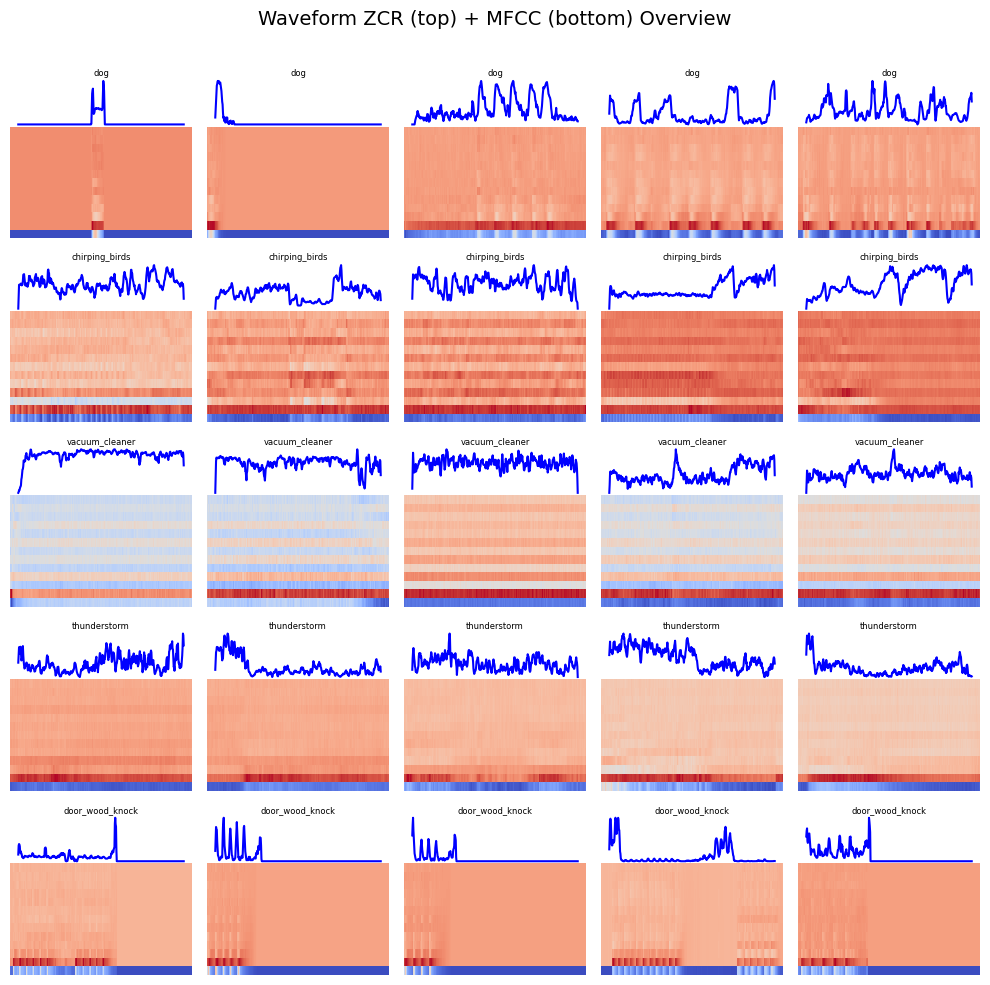

In [138]:
categories = 5
clips_per_cat = 5

samples = []
for category in df50['category'].unique()[:categories]:
    samples.extend(df50[df50['category'] == category].head(clips_per_cat).to_dict('records'))

fig, axes = plt.subplots(categories, clips_per_cat, figsize=(clips_per_cat*2, categories*2))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for idx, sample in enumerate(samples):
    row = idx // clips_per_cat
    col = idx % clips_per_cat
    ax = axes[row, col]
    plot_clip_zcr_mfcc(sample['filepath'], sample['category'], ax)

plt.suptitle("Waveform ZCR (top) + MFCC (bottom) Overview", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The ESC-50 dataset, with its larger number of categories, presents a greater challenge—particularly due to the increased likelihood of ambiguous recordings and the presence of background noise, which can make some sounds harder to distinguish.

### Models

In the following task we will do model ensembling using `SVM`, `knn`, `Random Forest`. We use `PCA` as well to reduce number of components

In [74]:
class ESCExperiment:
    """
    Run cross-validated experiments with optional PCA.
    """
    def __init__(self, X, y, folds, pca=None):
        self.X = X if pca is None else pca.fit_transform(X)
        self.y = y
        self.folds = folds
        self.models = {
            'knn': KNeighborsClassifier(n_neighbors=8),
            'rf': RandomForestClassifier(n_estimators=500, random_state=42),
            'svm': SVC(kernel='linear', C=0.1)
        }

    def run(self, model_key):
        accs, conf_sum = [], None
        for fold in sorted(self.folds.unique()):
            train_idx = self.folds != fold
            test_idx = self.folds == fold
            X_train, X_test = self.X[train_idx], self.X[test_idx]
            y_train, y_test = self.y[train_idx], self.y[test_idx]
            model = self.models[model_key]
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            accs.append(accuracy_score(y_test, preds))
            cm = confusion_matrix(y_test, preds)
            conf_sum = cm if conf_sum is None else conf_sum + cm
        mean_acc = np.mean(accs)
        print(f"{model_key.upper()} avg accuracy: {mean_acc*100:.1f}%")
        return {
            'model': model_key,
            'accs': accs,
            'mean_acc': mean_acc,
            'conf': conf_sum
        }


In [ ]:
results = []

Let's run experiments for 10 classes. All confusion matrices for each model are in a row. Category recall for different types of classifiers and human assessment are ploted as well.

ESC-10 experiments (no PCA) 
KNN avg accuracy: 68.2%
RF avg accuracy: 74.5%
SVM avg accuracy: 68.0%


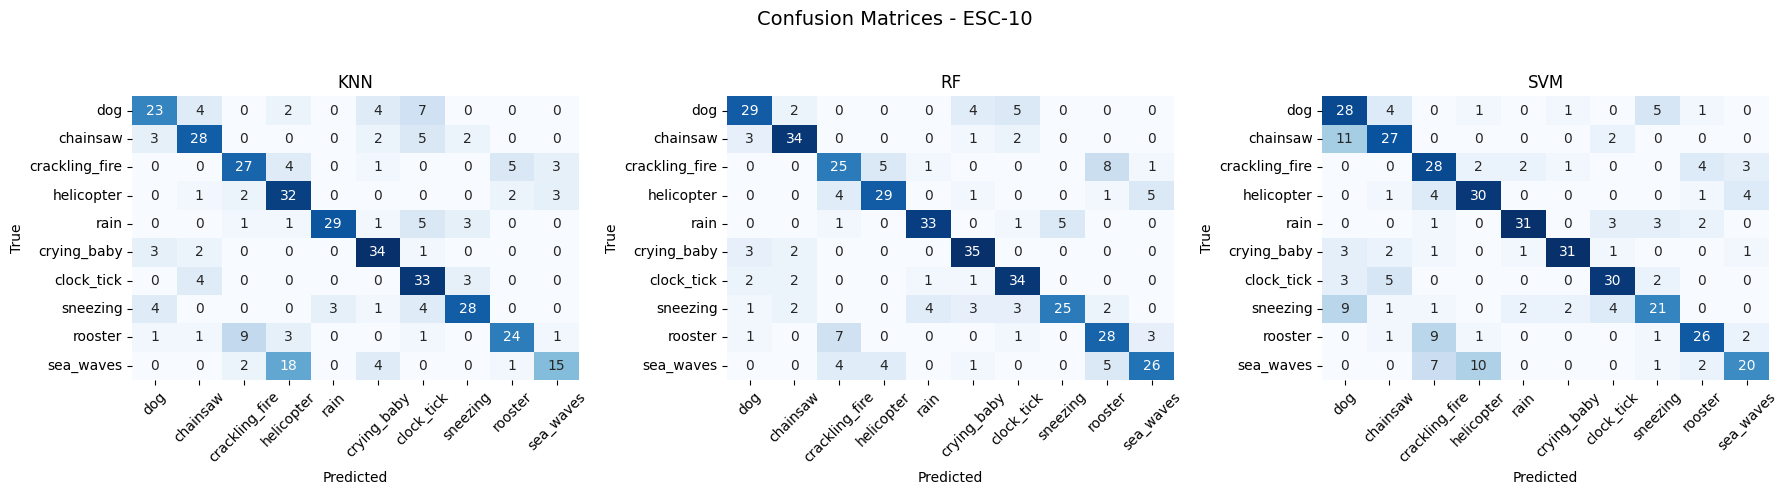

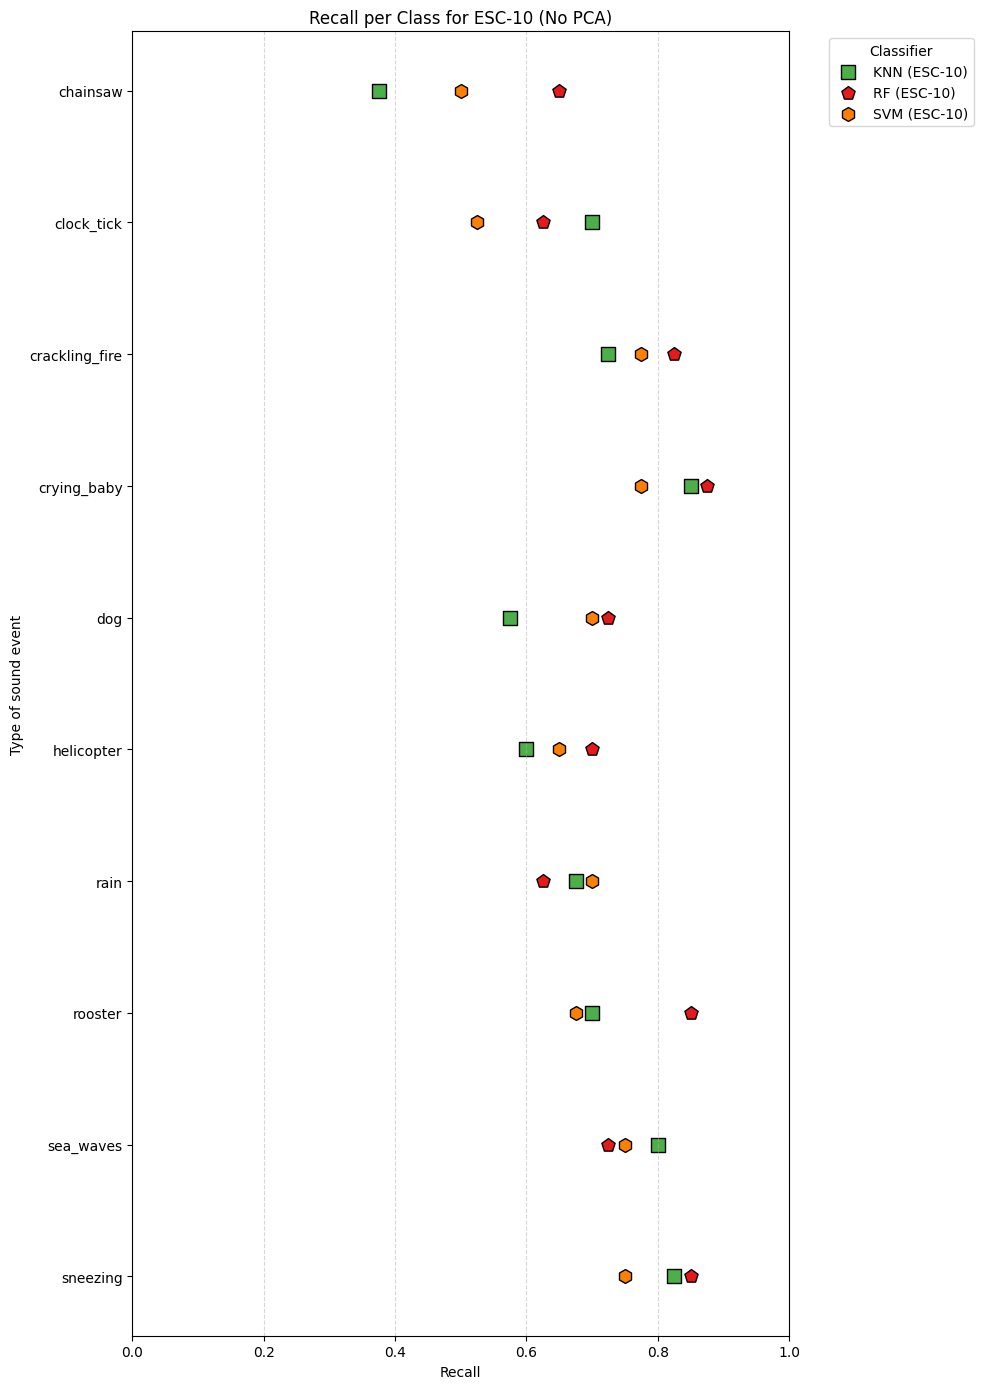

In [165]:
print("ESC-10 experiments (no PCA) ")
results10 = []
exp10 = ESCExperiment(X10, y10, folds10)
for clf in ['knn','rf','svm']:
    res = exp10.run(clf)
    res['dataset'] = 'ESC-10'
    res['pca'] = False
    results.append(res)
    results10.append(res)

plot_multiple_confusion_matrices(results10, df10_classes, dataset_type="ESC-10")
plot_classwise_recall_from_confusion(results10, df10, dataset_name="ESC-10", title_suffix="(No PCA)")

ESC-10 experiments (PCA=10) 
KNN avg accuracy: 68.0%
RF avg accuracy: 70.7%
SVM avg accuracy: 70.0%


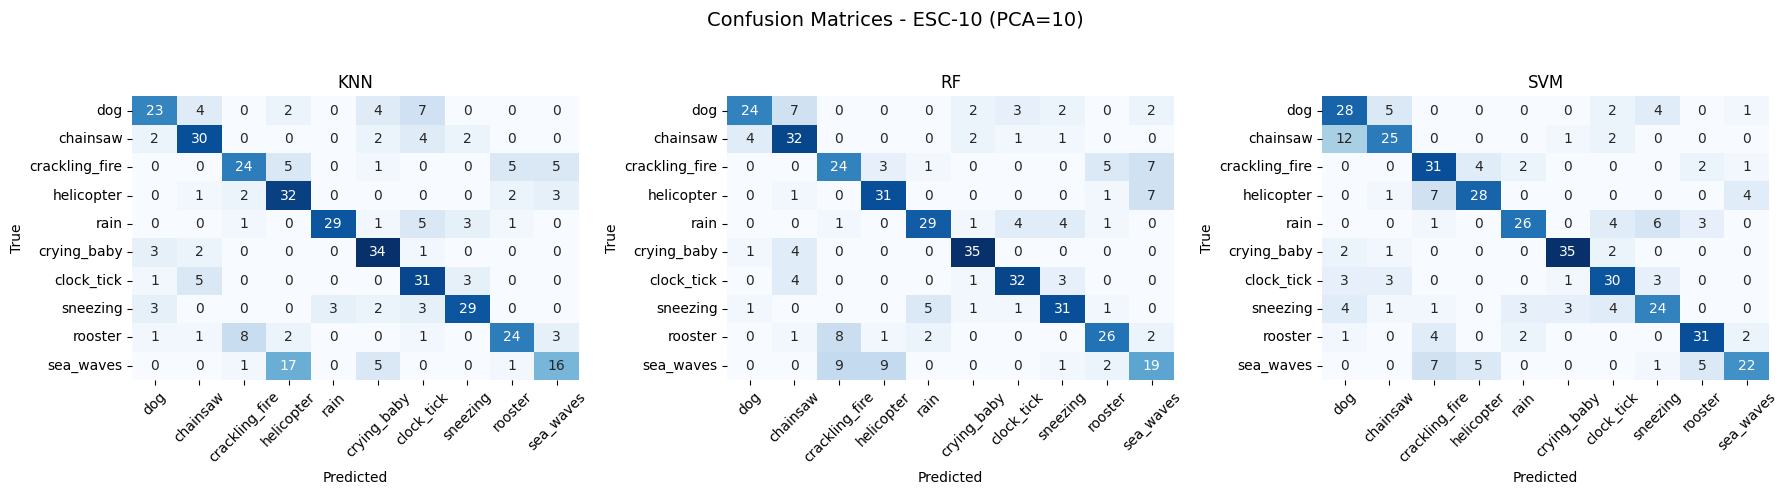

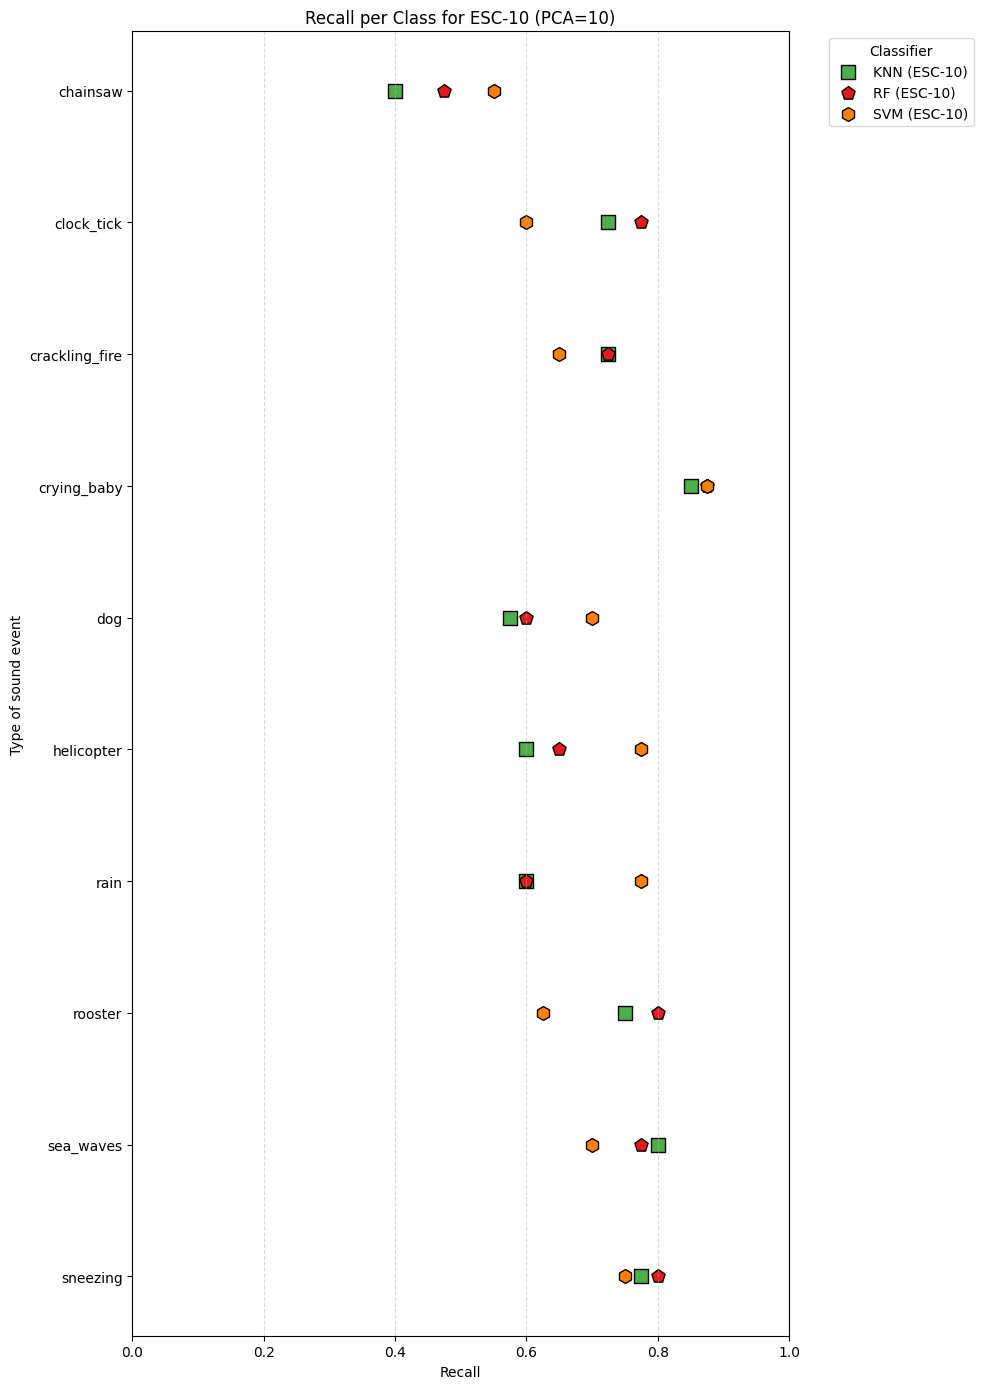

In [169]:
print("ESC-10 experiments (PCA=10) ")
results10_pca = []
exp10_pca = ESCExperiment(X10, y10, folds10, pca=PCA(n_components=10))
for clf in ['knn','rf','svm']:
    res = exp10_pca.run(clf)
    res['dataset'] = 'ESC-10'
    res['pca'] = True
    results.append(res)
    results10_pca.append(res)

plot_multiple_confusion_matrices(results10_pca, df10_classes, dataset_type="ESC-10 (PCA=10)")
plot_classwise_recall_from_confusion(results10_pca, df10, dataset_name="ESC-10", title_suffix="(PCA=10)")

For 50 classes I selected averege confusion matrix between all models to reduce size of this notebook

ESC-50 experiments (no PCA) 
KNN avg accuracy: 26.1%
RF avg accuracy: 46.0%
SVM avg accuracy: 42.2%


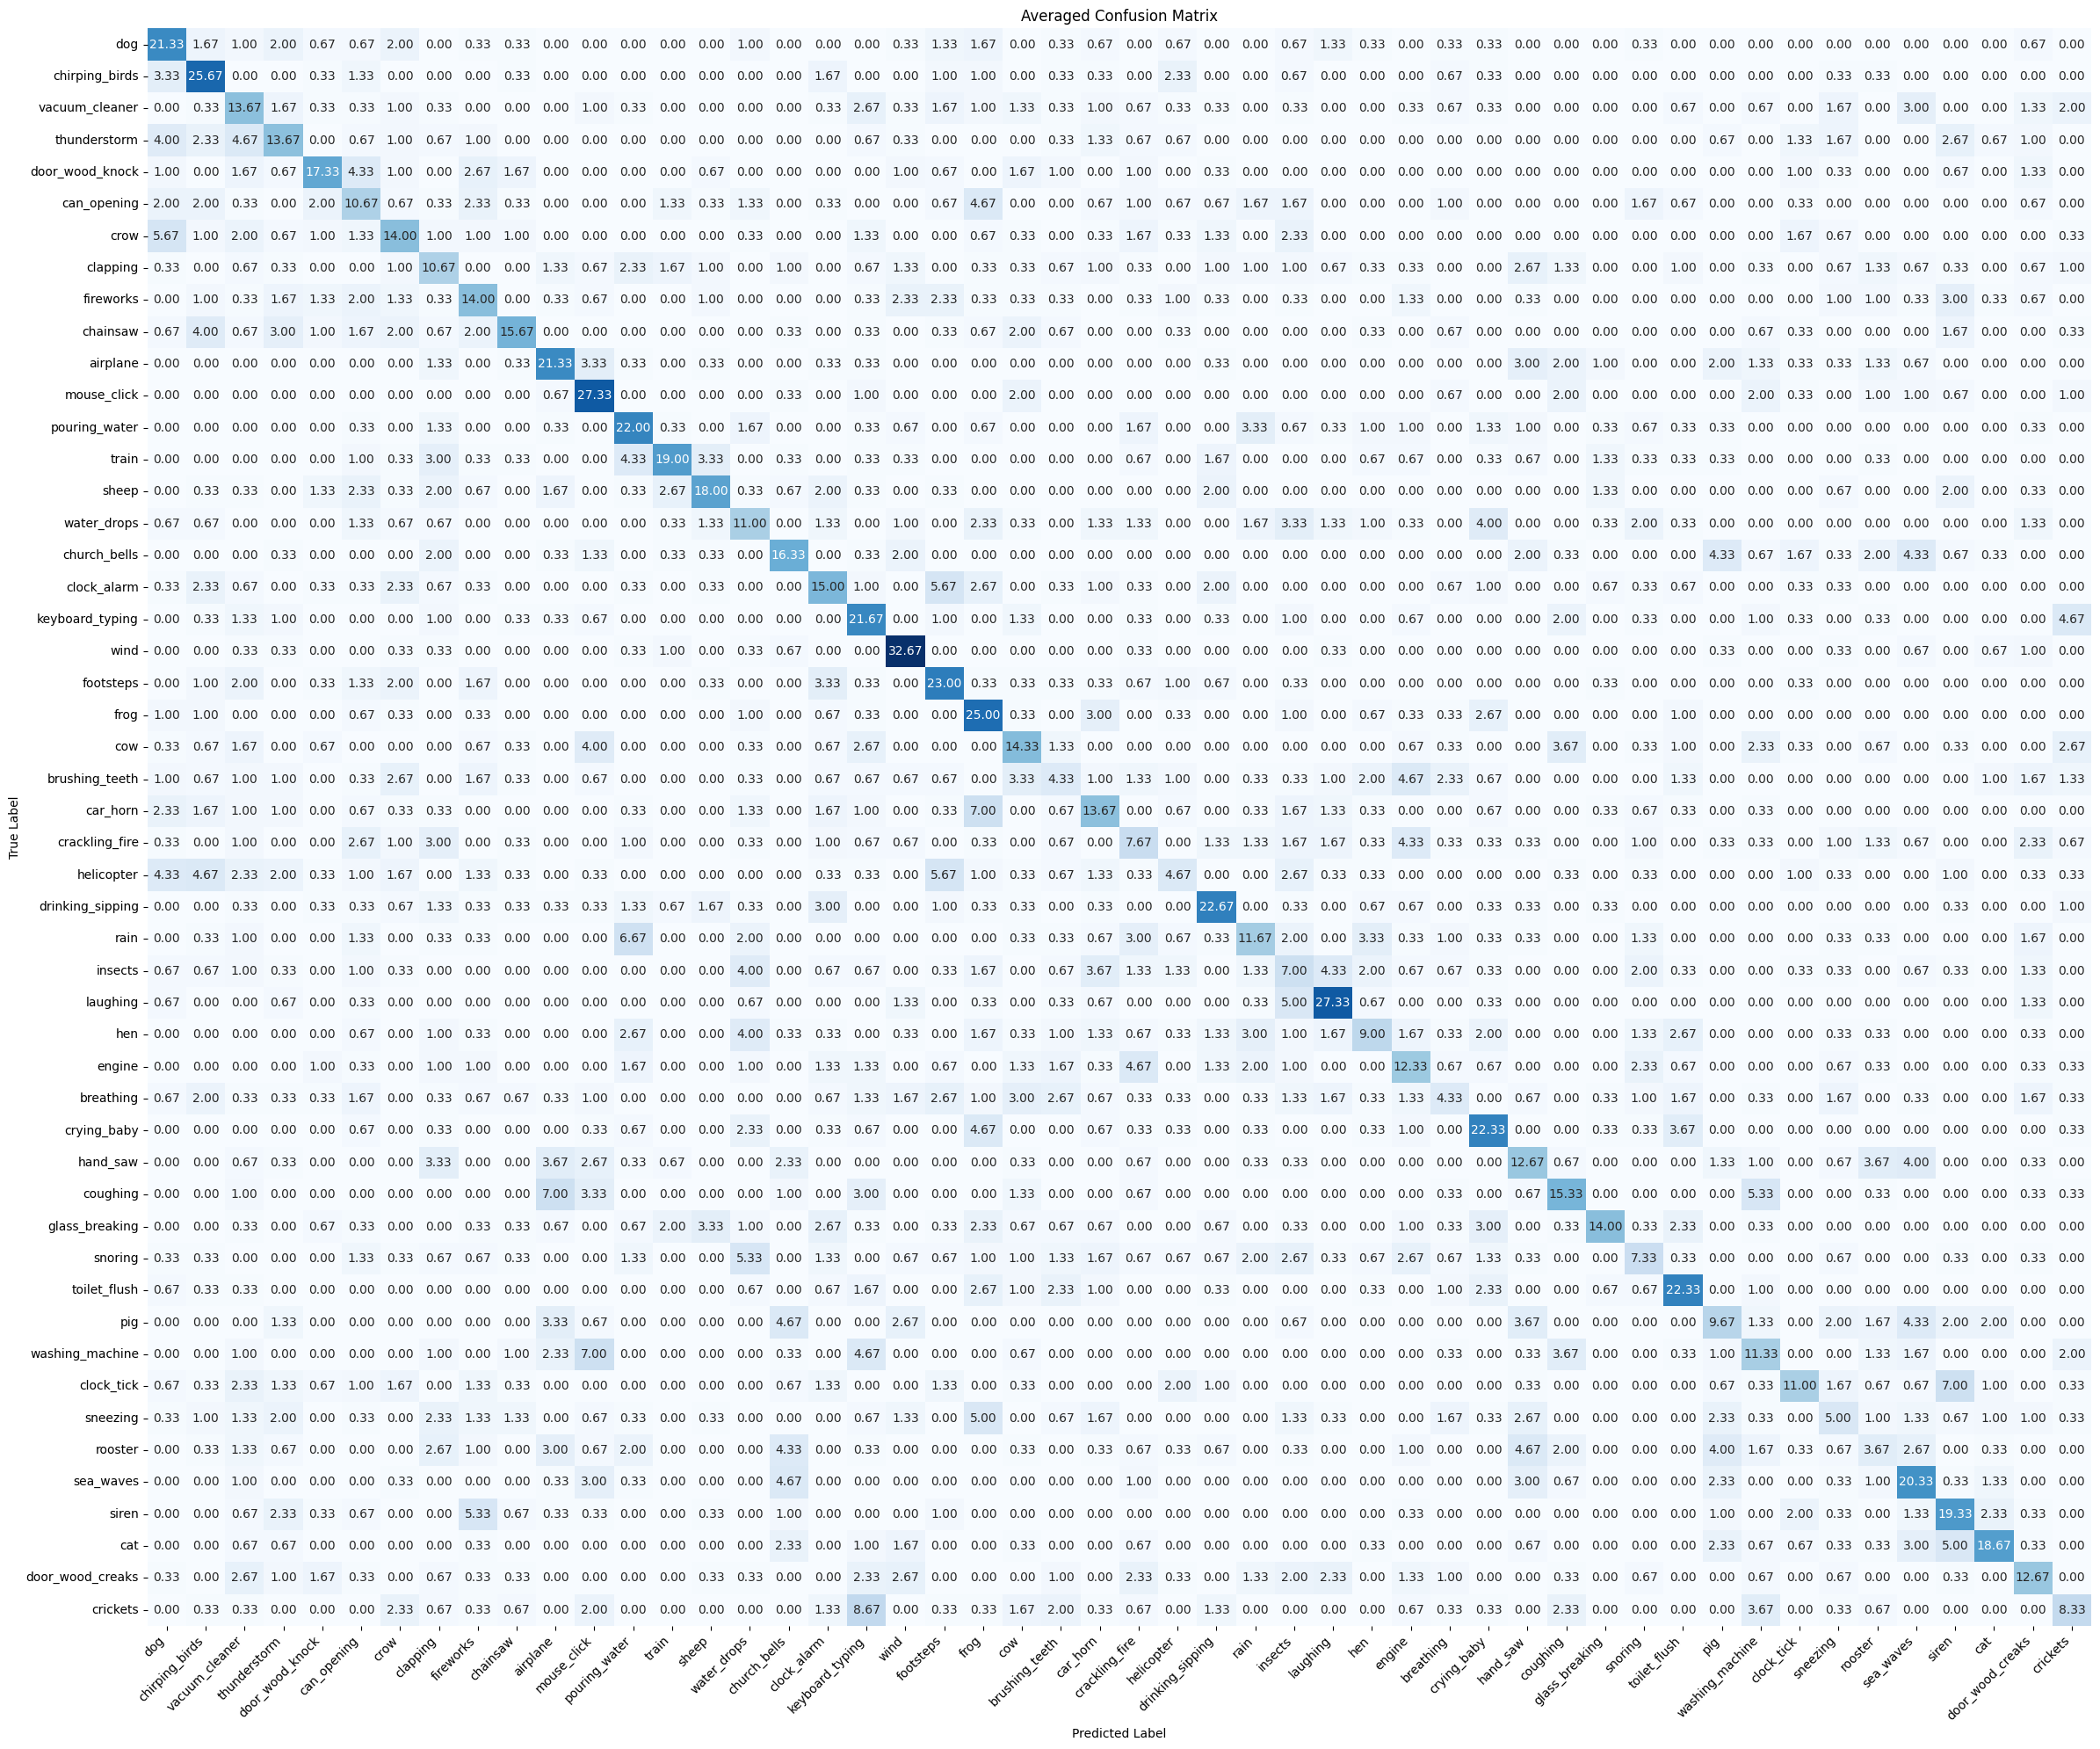

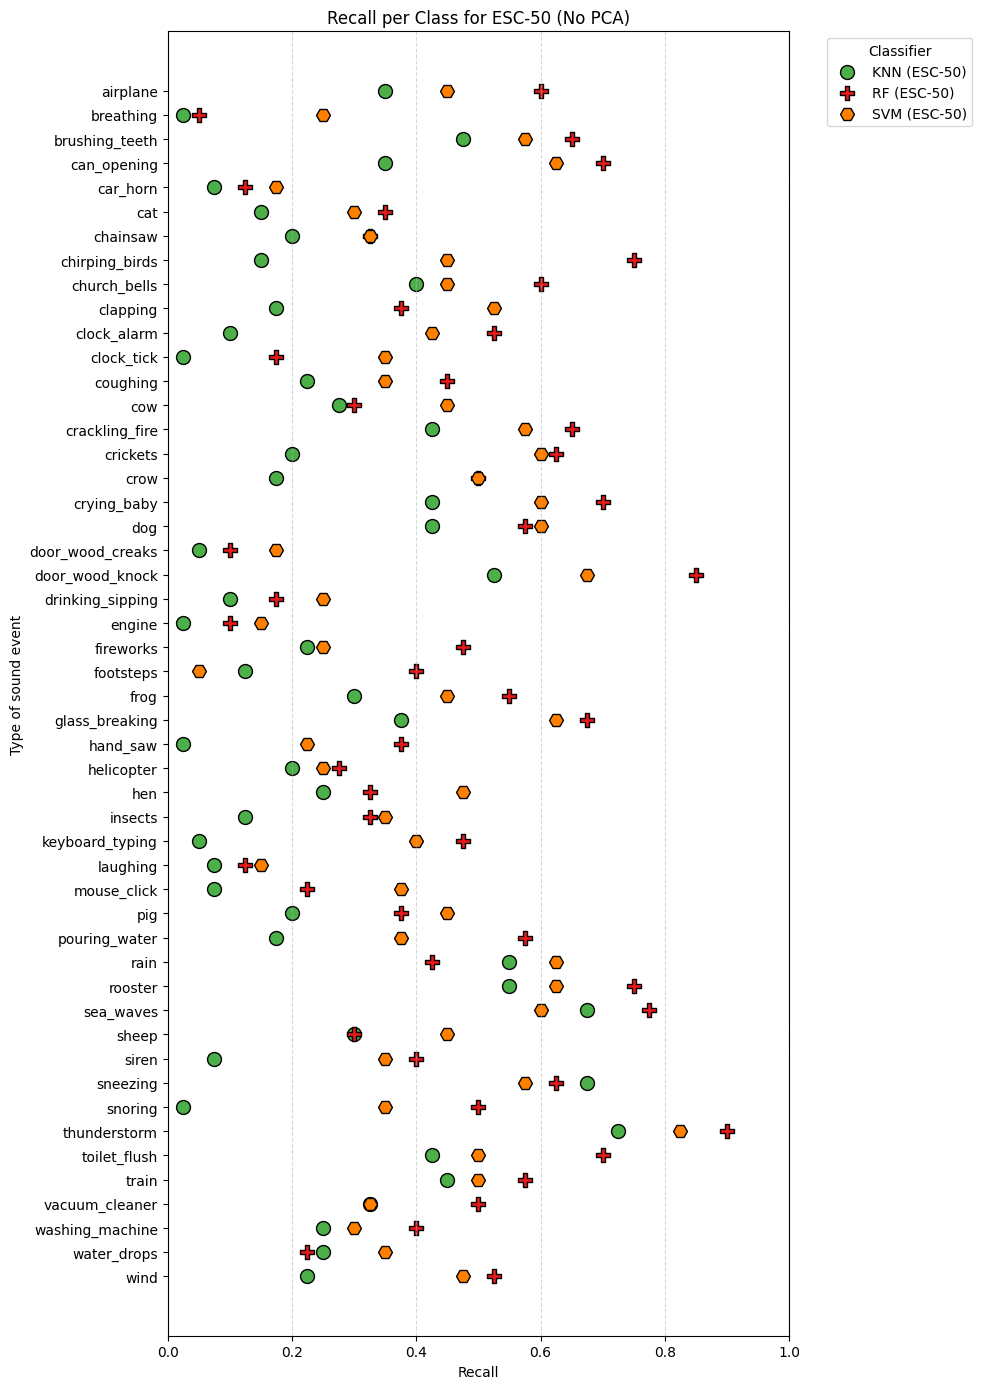

In [170]:
print("ESC-50 experiments (no PCA) ")
results50 = []
exp50 = ESCExperiment(X50, y50, folds50)
for clf in ['knn','rf','svm']:
    res = exp50.run(clf)
    res['dataset'] = 'ESC-50'
    res['pca'] = False
    results.append(res)
    results50.append(res)
plot_confusion_matrix(results50, df50_classes, average=True)
plot_classwise_recall_from_confusion(results50, df50, dataset_name="ESC-50", title_suffix="(No PCA)")

ESC-50 experiments (PCA=10) 
KNN avg accuracy: 25.3%
RF avg accuracy: 33.8%
SVM avg accuracy: 37.2%


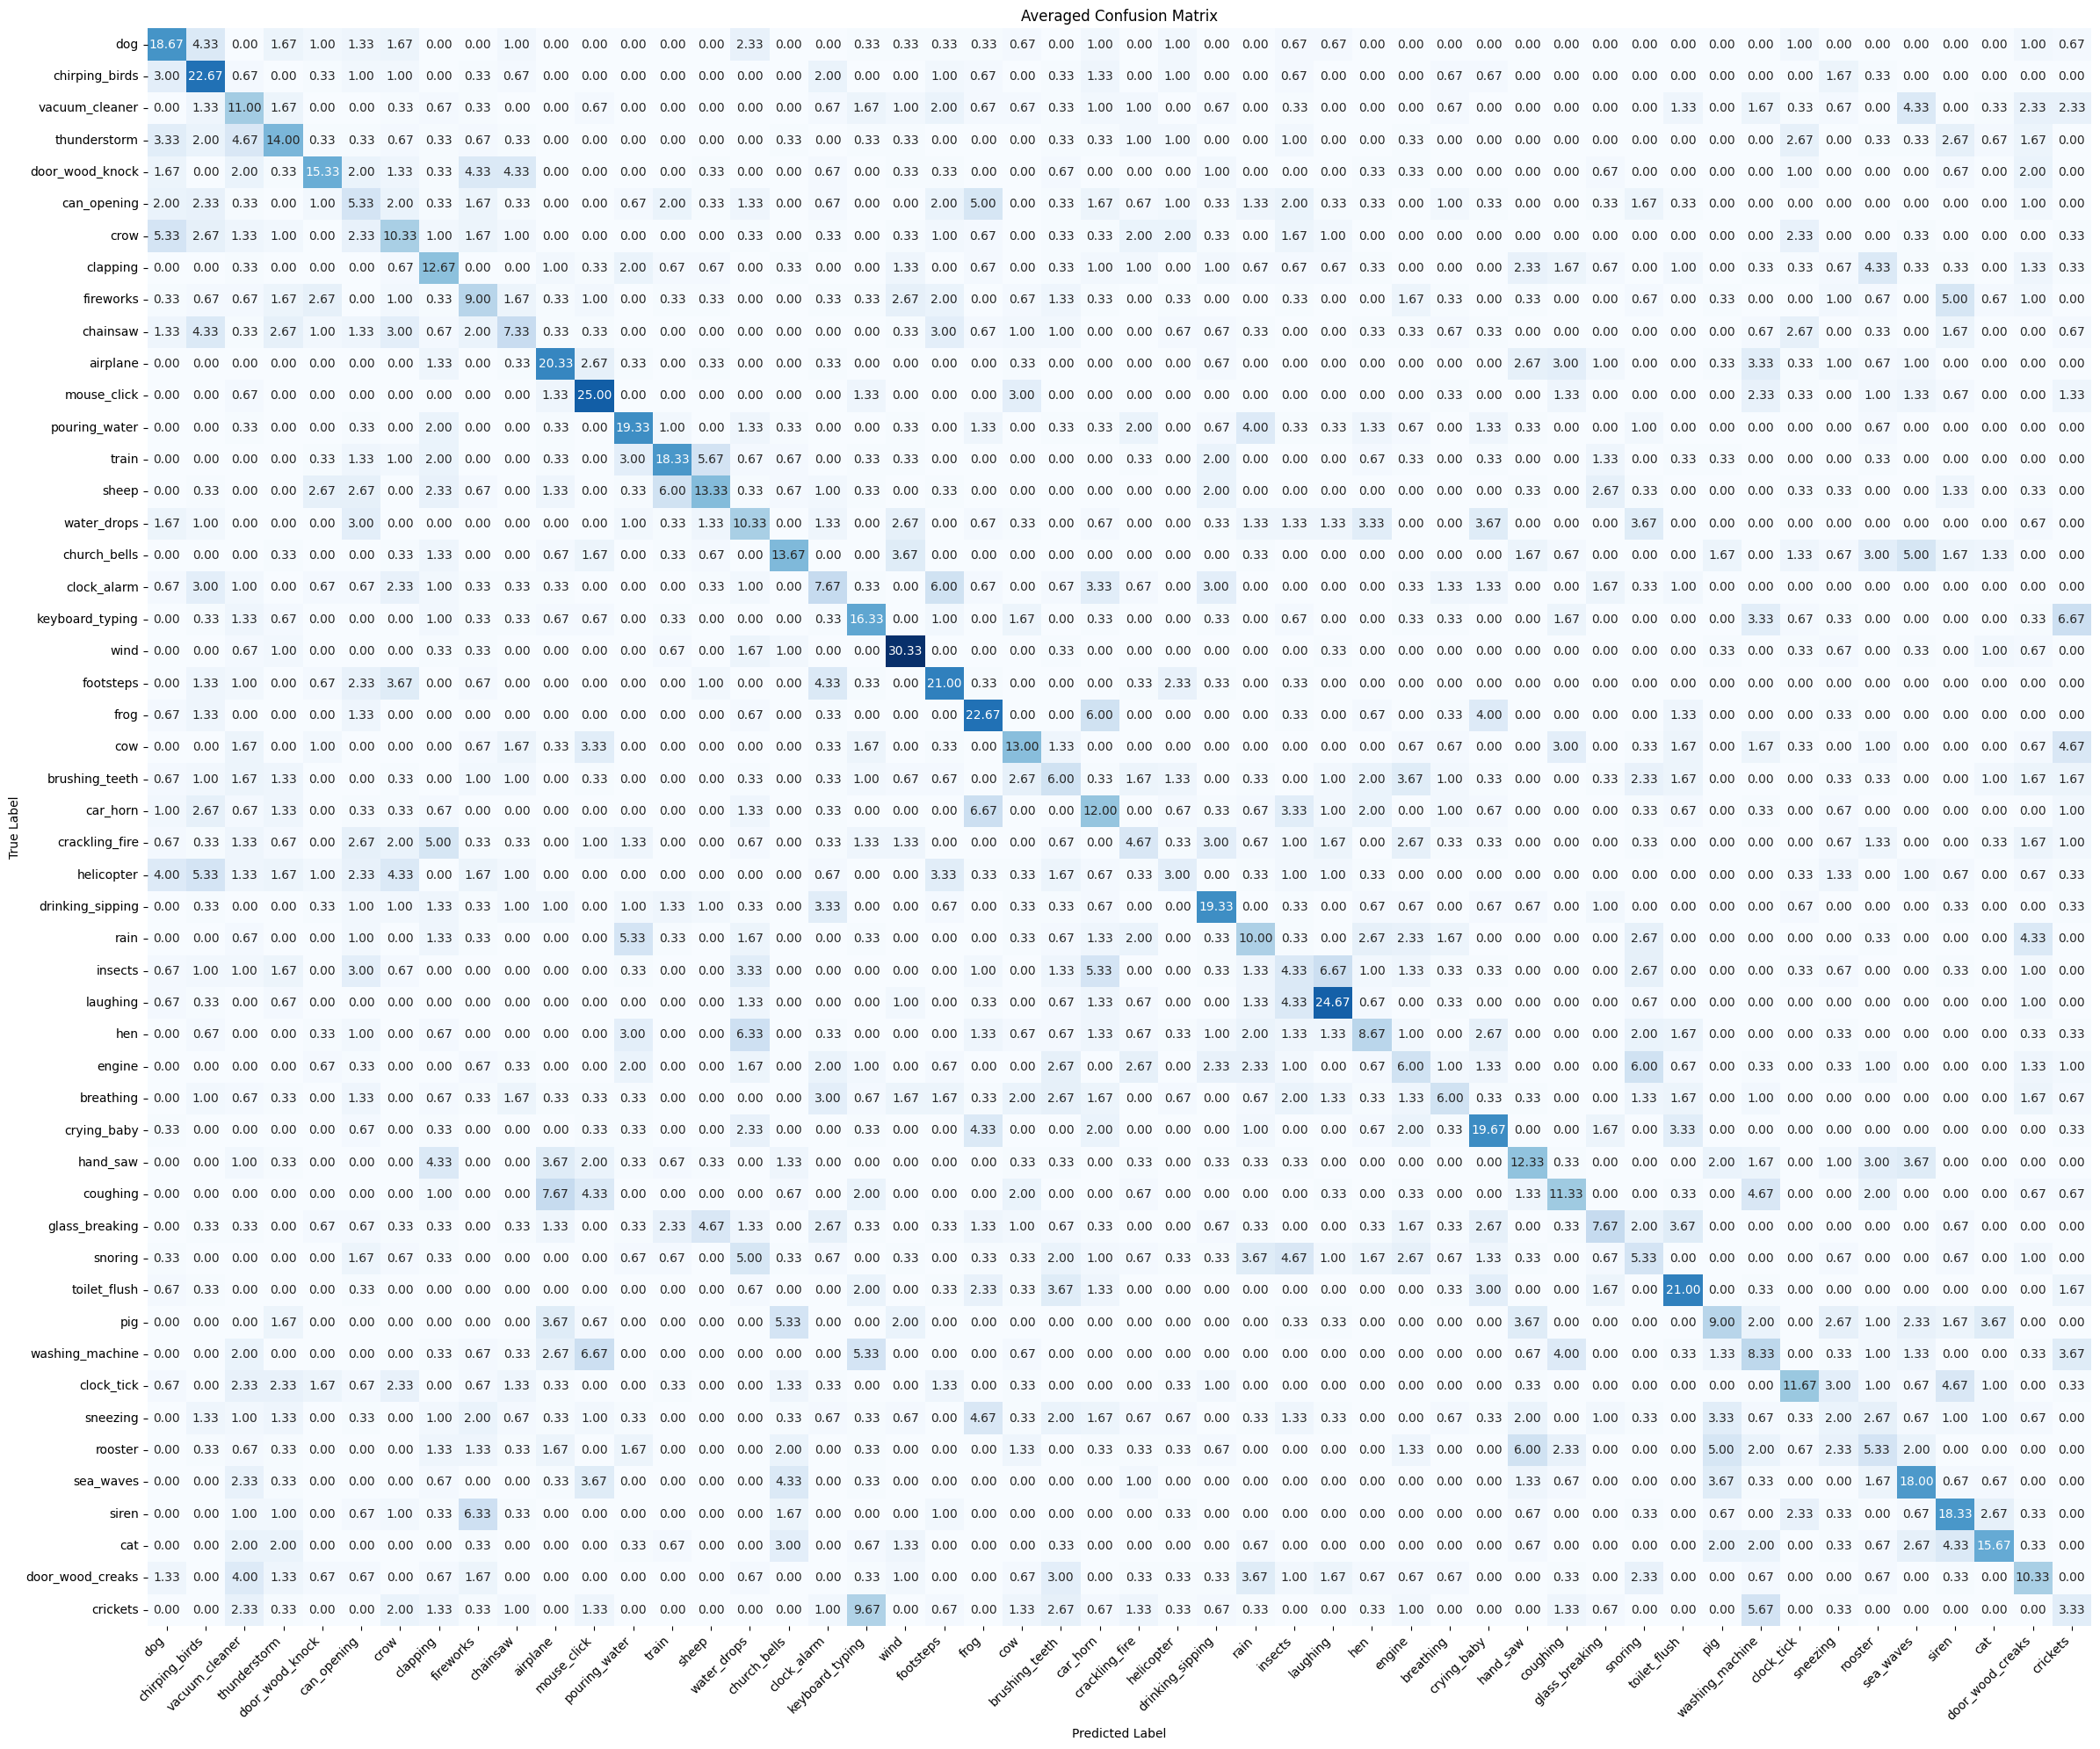

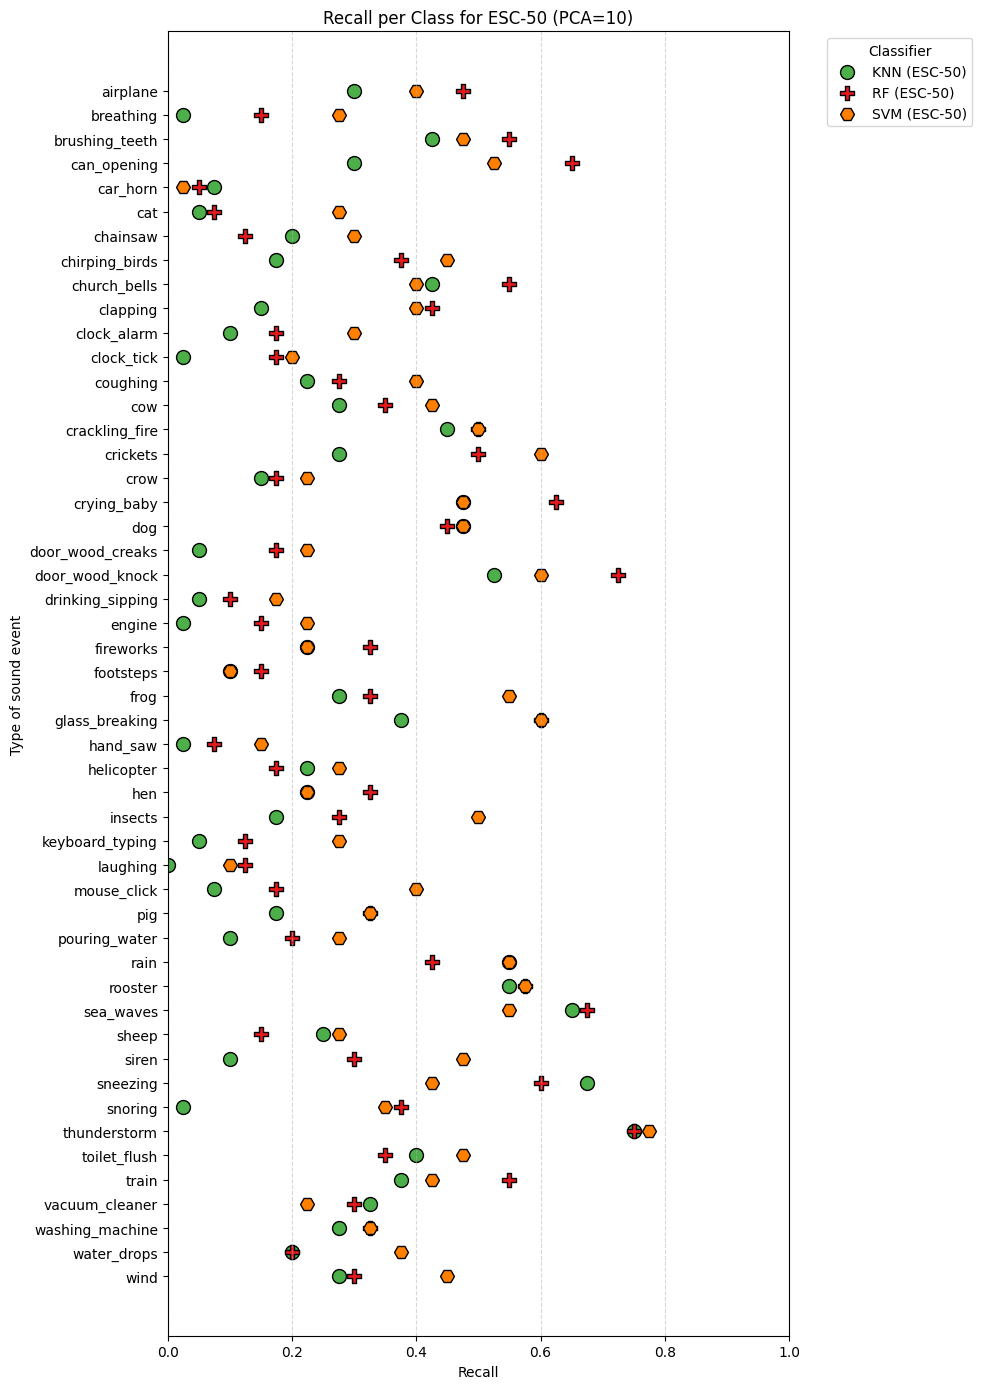

In [171]:
print("ESC-50 experiments (PCA=10) ")
results50_pca = []
exp50_pca = ESCExperiment(X50, y50, folds50, pca=PCA(n_components=10))
for clf in ['knn','rf','svm']:
    res = exp50_pca.run(clf)
    res['dataset'] = 'ESC-50'
    res['pca'] = True
    results.append(res)
    results50_pca.append(res)
plot_confusion_matrix(results50_pca, df50_classes, average=True)
plot_classwise_recall_from_confusion(results50_pca, df50, dataset_name="ESC-50", title_suffix="(PCA=10)")

Comparison of classification accuracy between folds depending on the choice of classifier.

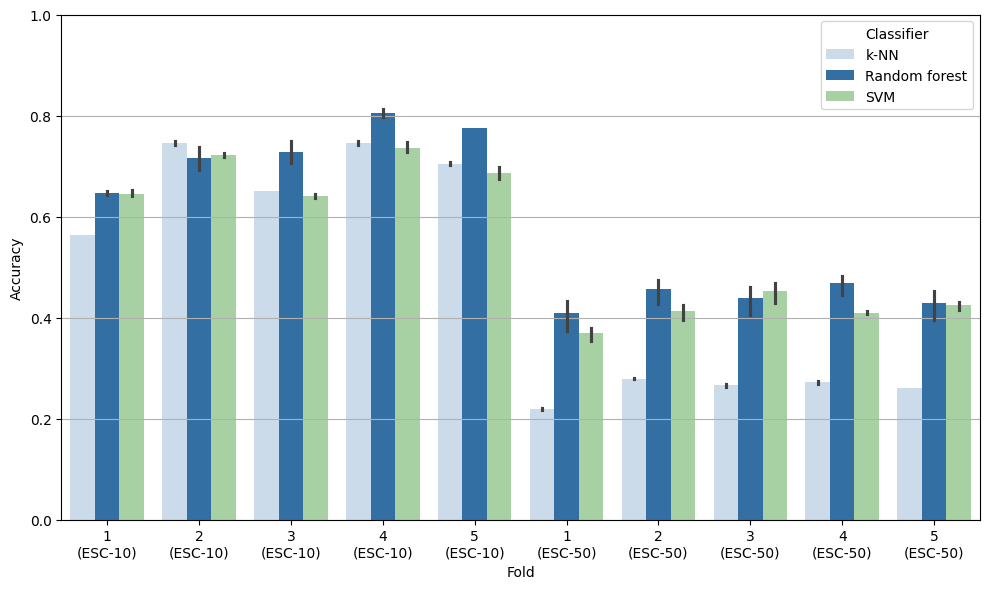

In [ ]:
flat_records = []
for res in results:
    for fold_idx, acc in enumerate(res['accs'], 1):
        flat_records.append({
            'Classifier': res['model'].replace('knn', 'k-NN').replace('rf', 'Random forest').replace('svm', 'SVM'),
            'Dataset': res['dataset'],
            'Fold': fold_idx,
            'Accuracy': acc
        })

df_long = pd.DataFrame(flat_records)

df_long['FoldGroup'] = df_long['Fold'].astype(str)
df_long.loc[df_long['Dataset'] == 'ESC-10', 'FoldGroup'] = df_long['Fold'].astype(str) + '\n(ESC-10)'
df_long.loc[df_long['Dataset'] == 'ESC-50', 'FoldGroup'] = df_long['Fold'].astype(str) + '\n(ESC-50)'

palette = {
    'k-NN': '#c6dbef',
    'Random forest': '#2171b5',
    'SVM': '#a1d99b'
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_long,
    x='FoldGroup',
    y='Accuracy',
    hue='Classifier',
    palette=palette
)

plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('')
plt.ylim(0, 1)
plt.legend(title='Classifier')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Conclusion

This paper explores classical machine learning methods for environmental sound classification using the ESC datasets. By analyzing traditional models like k-NN, SVM, and Random Forest, it aims to establish strong baselines and better understand their performance on these publicly available audio benchmarks. This work contributes to the broader research effort by highlighting the value of simple, interpretable models in a field increasingly dominated by deep learning(Yes thats true I have no free gpu left :) ).